#### Importing Data and Formatting Dataframe

In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams

%matplotlib inline

In [2]:
tyc_r = quandl.get("USTREASURY/YIELD", authtoken="aG9j5L1aZEe7Gti-5m1D")

In [3]:
tyc_r = tyc_r[['10 YR']]
tyc_r = tyc_r.loc['1996-12-31':]

In [4]:
tyc_r.index.names = ['Date']

In [6]:
tyc_r

,10 YR
Date,
1996-12-31,6.43
1997-01-02,6.54
1997-01-03,6.52
1997-01-06,6.54
1997-01-07,6.57
...,...
2020-07-21,0.61
2020-07-22,0.60
2020-07-23,0.59


In [7]:
df = tyc_r

In [8]:
df_weekly = df.resample('W')
df_weekly = df_weekly.mean()

df_monthly = df.resample('MS')
df_monthly = df_monthly.mean()

In [43]:
# pd.set_option('display.max_rows', 100)

In [9]:
df['2020-04-20':]

,10 YR
Date,
2020-04-20,0.63
2020-04-21,0.58
2020-04-22,0.63
2020-04-23,0.61
2020-04-24,0.60
...,...
2020-07-21,0.61
2020-07-22,0.60
2020-07-23,0.59


#### Plotting Data and Statistics

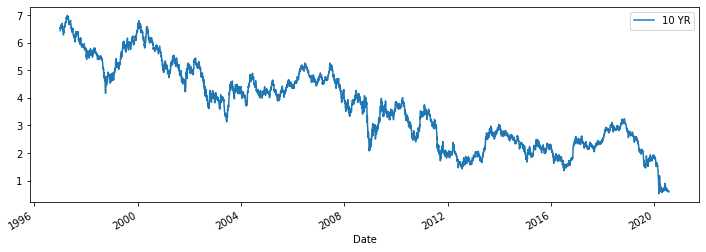

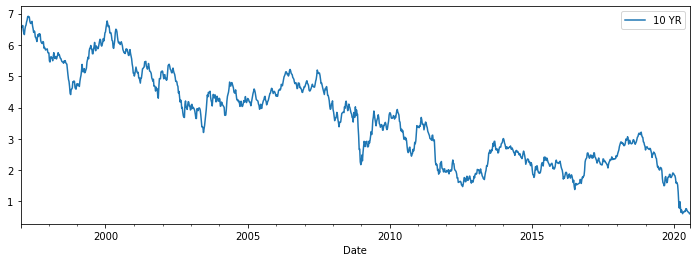

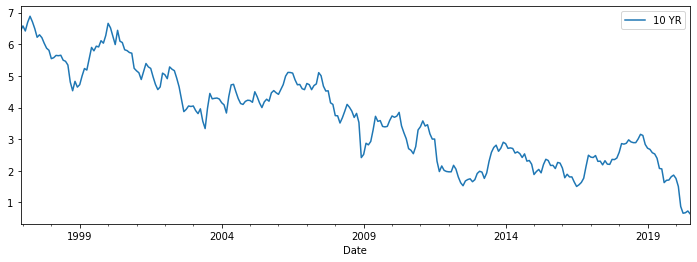

In [11]:
df_list = [df, df_weekly, df_monthly]

for thing in df_list:
    thing.plot(figsize = (12, 4))

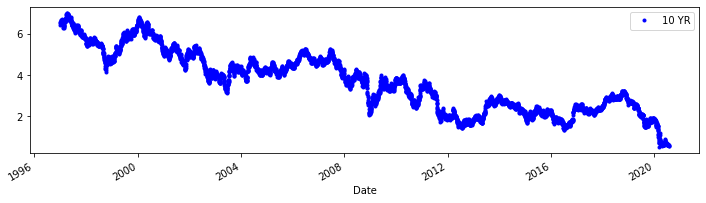

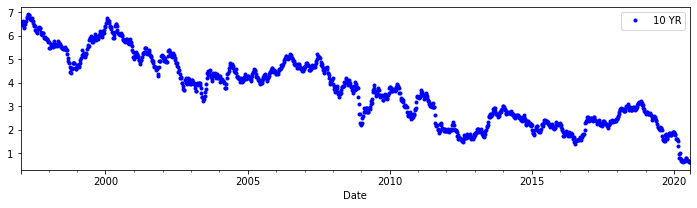

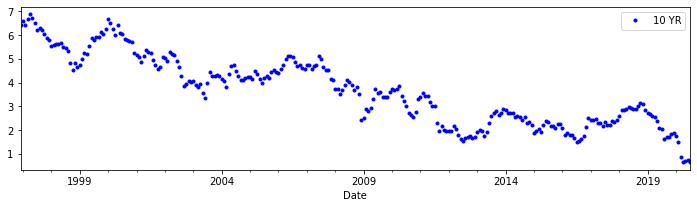

In [12]:
for thing in df_list:
    thing.plot(figsize = (12,3), style = '.b')

In [13]:
roll_mean = df.rolling(window=365, center=False).mean()
roll_std = df.rolling(window=365, center=False).std()

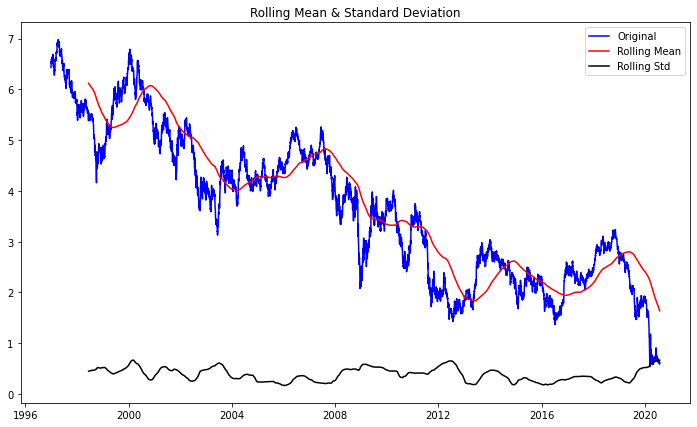

In [14]:
# daily plot
fig = plt.figure(figsize=(12,7))
plt.plot(df, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [17]:
roll_mean = df_weekly.rolling(window=52, center=False).mean()
roll_std = df_weekly.rolling(window=52, center=False).std()

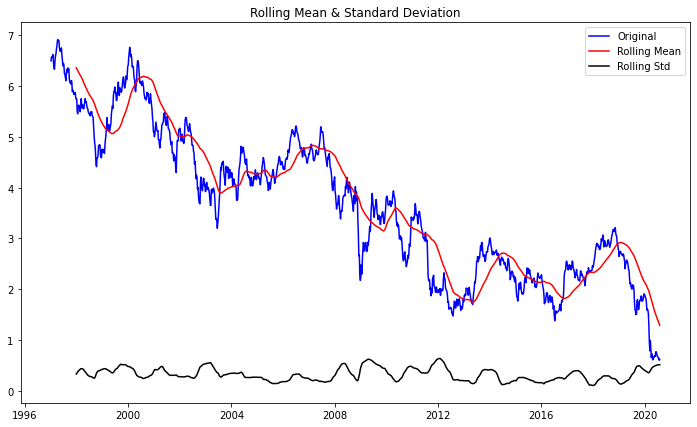

In [19]:
# weekly plot
fig = plt.figure(figsize=(12,7))
plt.plot(df_weekly, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [20]:
roll_mean = df_monthly.rolling(window=12, center=False).mean()
roll_std = df_monthly.rolling(window=12, center=False).std()

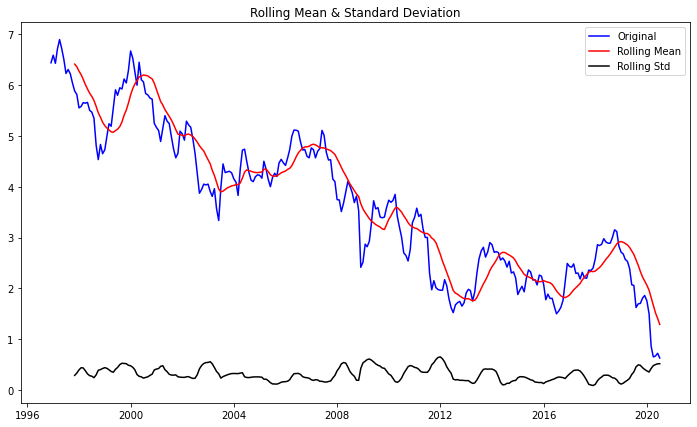

In [21]:
# monthly plot
fig = plt.figure(figsize=(12,7))
plt.plot(df_monthly, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

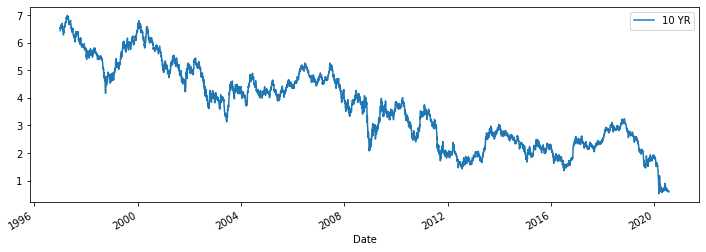

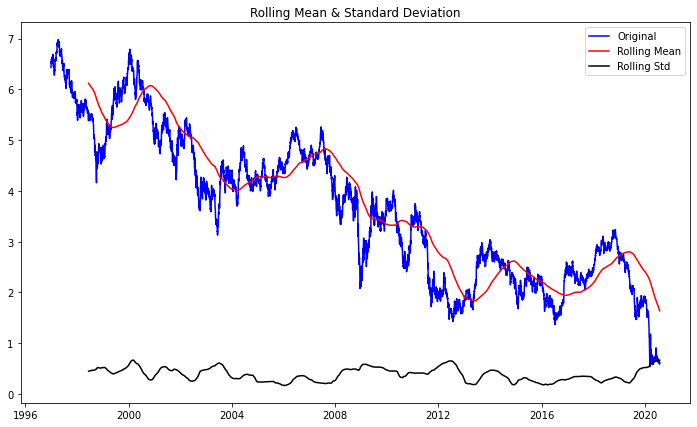

In [22]:
df.plot(figsize = (12, 4))
roll_mean = df.rolling(window=365, center=False).mean()
roll_std = df.rolling(window=365, center=False).std()
fig = plt.figure(figsize=(12,7))
plt.plot(df, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### Dickey-Fuller Test

In [23]:
dftest = adfuller(df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-1.3695208795376759, 0.5967978614523437, 2, 5894, {'1%': -3.4314599678092206, '5%': -2.862030502122538, '10%': -2.5670310920574075}, -16902.39361507823)


In [24]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                   -1.369521
p-value                           0.596798
#Lags Used                        2.000000
Number of Observations Used    5894.000000
Critical Value (1%)              -3.431460
Critical Value (5%)              -2.862031
Critical Value (10%)             -2.567031
dtype: float64


In [25]:
##### this time series does not pass the dickey fuller test, meaning it is non-stationary
##### cannot reject the null hypothesis which states that the series is non-stationary
##### therefore, the data needs to be differenced before modeling can begin

#### Modeling

In [26]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df[:'2020-04-20'], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 0, 0, 2), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0344      0.918     -0.038      0.970      -1.833       1.764
ma.L1          0.0463      0.918      0.050      0.960      -1.752       1.845
sigma2         0.0033   4.05e-05     81.314      0.000       0.003       0.003


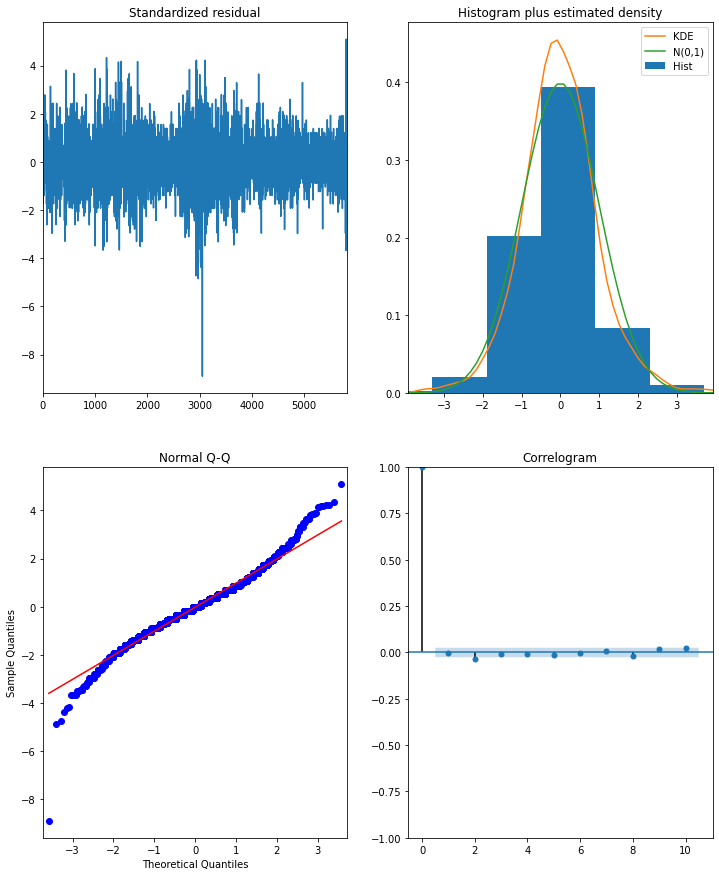

In [27]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 15))
plt.show()

In [28]:
# Get predictions starting from 01-01-2020 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2020-01-02'), dynamic=False)
pred_conf = pred.conf_int()

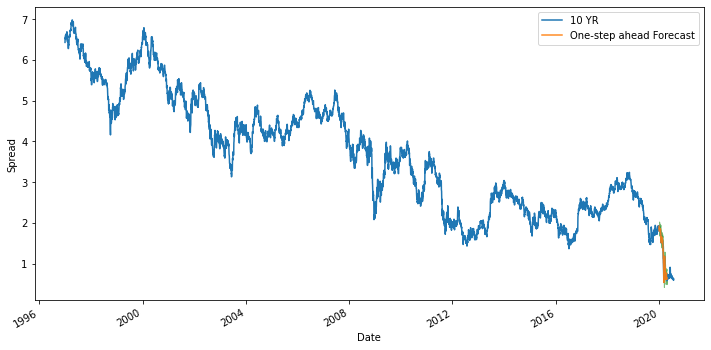

In [29]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 12, 6

# Plot observed values
ax = df['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Spread')
plt.legend()

plt.show()

#### Results

In [30]:
# Get the real and predicted values
spread_forecasted = pred.predicted_mean
spread_truth = df['2020-01-02':'2020-04-20']

In [31]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)

0.007053431276055953

#### Forecasting

In [32]:
forecast_5= output.forecast(steps=5)
forecast_30 = output.forecast(steps=30)
forecast_60 = output.forecast(steps=60)
forecast_90 = output.forecast(steps=90)
forecast_120 = output.forecast(steps=120)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported ind

In [33]:
# Get the real and predicted values
spread_forecasted = forecast_5
spread_truth = df['2020-04-20':'2020-04-24']

In [34]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)


0.000750047129135111

In [35]:
# Get the real and predicted values
spread_forecasted = forecast_30
spread_truth = df['2020-04-20':'2020-06-01']

In [36]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)


0.002190929045879798

In [37]:
# Get the real and predicted values
spread_forecasted = forecast_60
spread_truth = df['2020-04-20':'2020-07-14']

In [38]:
y_truth = spread_truth
y_forecasted = spread_forecasted
mean_squared_error(y_truth , y_forecasted)


0.00683379061931703